## Import

In [1]:
import numpy as np
np.random.seed(2023)
import pandas as pd
import FinanceDataReader as fdr
from scipy.optimize import minimize
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
# 개별 주식데이터를 불러온다.
stock_list = [["삼성전자", "005930"],["SK하이닉스", "000660"],["현대차", "005380"],
              ["셀트리온", "068270"],["LG화학", "051910"],["POSCO", "005490"],["삼성물산", "028260"],["NAVER", "035420"]]
stocks = pd.concat([fdr.DataReader(code, '2021-01-01', '2023-09-11')['Close'].rename(name) for name, code in stock_list], axis=1)
stocks.shape

(667, 8)

In [3]:
# 종합주가지수(KOSPI)를 불러온다.
kospi = fdr.DataReader('KS11', '2021-01-01', '2023-09-11')['Close'].rename('kospi')
kospi.shape

(664,)

In [4]:
data = pd.concat([stocks,kospi], axis=1)
data.shape

(667, 9)

## CAPM
효율적 시장 내 균형상태(수요와 공급이 일치되도록 가격이 형성된 상태)에서 자산의 기대수익률과 위험간 관계를 설명한 가격결정이론이다.
- 균형상태인 접점포트폴리오는 시장포트폴리오라고 하며 시장포트폴리오가 위험자산의 시장가치대로 구성되지 않으면 자산에 대한 초과수요나 초과공급이 발생해 균형이 흐트러진다.
- CAPM은 아래의 가정을 갖는다.<br>
  $\bullet$ 대부분의 투자자는 위험회피 성향을 띄며 평균-분산 포트폴리오를 기준으로 포트폴리오를 선택한다.<br>
  $\bullet$ 증권시장은 완전경쟁시장이며 공급은 고정되어있고 거래비용 세금과 공매도 제한은 없다.<br>
  $~$ 시장정보는 누구에게나 자유롭게 전달된다.(비현실적 가정)<br>
  $\bullet$ 모든 투자자는 기대수익률, 분산, 공분산에 대한 같은 기대를 한다. 즉, 도박성 투자자는 없다.<br>
  $\bullet$ 무위험자산이 존재하며 모든 투자자는 무위험이자율로 얼마든 자금을 빌려주거나 차업할 수 있다.<br>
  $\bullet$ 투자 대상은 공개적으로 거래되는 금융자산으로 한정한다.
- SML(증권시장선), CML(자본시장선) 등을 통해 이론을 펼친다.

## SML
시장에서 거래되는 모든 자산에 대해 균형상태 하의 기대수익률과 위험간의 관계를 나타낸다.
$$\large E(r_i) = r_f + [E(r_m) - r_f] \times \beta_i = r_f + \text{시장리스크프리미엄} \times \beta_i$$
$$(E(r_i): \text{자산}i\text{의 기대수익률}, r_f: \text{무위험이자율}, E(r_m): \text{시장포트폴리오의 기대수익률})$$
- $\beta_i$는 해당 자산과 시장수익률간 상관관계(변동성)을 의미하며 동시에 해당 종목의 투자시장 진입하는 모두에게 발생하는 위험(시장위험)을 의미한다.
- $\beta_i$의 의미에 따라 SML로 설명되는 자산 $i$의 수익률은 체계적 위험에 상응하는 요구수익률이자 기업 가치를 반영한 자기자본비용 또는 주식평가를 위한 적정할인율을 의미한다.
- $\beta$가 클수록 대형주, 작을수록 소형주이고 $\beta$가 1에 가까우면 시장흐름을 잘 따라간다는 뜻이다.
- SML은 자산의 기대수익률과 `자산의 위험`($\beta$)의 선형관계식이다. 즉, 위험을 주가변동성으로 본다. 
- 자산의 $\beta$에 대한 SML의 기대수익률(Y값)보다 자산의 기대수익률이 높다면 과소평가된 자산이다.<br> 추후 자산 매입수요가 늘고 기대수익률이 낮아지며 SML에 위치하게 될 것이다.
- 반대로, 자산의 $\beta$에 대한 SML의 기대수익률(Y값)보다 자산의 기대수익률이 낮다면 과대평가된 자산이다.<br> 추후 자산 매도수요가 늘고 기대수익률이 높아지며 SML에 위치하게 될 것이다.

## CML
시장포트폴리오와 무위험자산으로 분산투자한 경우에 대해 균형상태 하의 기대수익률과 위험간의 관계를 나타낸다.
$$\large E(r_p) = r_f + \frac{E(r_m)-r_f}{\sigma_m} \times \sigma_p$$
- 효율적 시장을 가정하는 만큼, 비효율적 포트폴리오의 기대수익률과 위험간 관계는 설명하지 못한다.

## 시장모형
현실적으로 시장포트폴리오를 찾기 어려워 CAPM에서 시장포트폴리오 대신 `종합주가지수`를 사용한 가격결정모형이다.
- 증권특성선(SCL)의 $\beta$는 아래와 같다. $\beta$는 회귀분석을 통해 추정한다.
  $$\large r_i = \alpha_i + \beta_i r_M + e_i, \beta_i = \frac{COV(r_i, r_M)}{Var(r_M)} = \frac{\sigma_{iM}}{\sigma^2_M} = \frac{\rho_{iM}\cdot\sigma_i}{\sigma_M}$$
- $\alpha_i$는 기업 가치를 의미한다.

## Example 1
SCL의 수식을 사용해 $\beta$를 구해보라.

In [5]:
# 1. 월별 수익률을 구한다.
# pct_change(n)은 k번째 데이터와 k-n번째 데이터로 구한 수익률을 의미한다.
data_m = data.resample('M').last().dropna().pct_change(1)
data_m.sample(5)

,삼성전자,SK하이닉스,현대차,셀트리온,LG화학,POSCO,삼성물산,NAVER,kospi
Date,,,,,,,,,
2023-07-31,-0.033241,0.071181,-0.050847,-0.041203,-0.028486,0.654639,-0.022706,0.241794,0.026635
2021-05-31,-0.012270,-0.007812,0.108491,0.031954,-0.121245,-0.024725,0.018382,0.008345,0.017809
2022-05-31,0.000000,-0.040000,0.018817,-0.088069,0.127168,0.000000,0.047619,0.005236,-0.003395
2022-08-31,-0.027687,-0.027579,0.000000,-0.002634,0.048093,0.053719,0.000000,-0.073359,0.008383
2021-10-31,-0.058030,0.000000,0.040000,-0.227361,0.077320,-0.103030,-0.076923,0.048969,-0.031980


In [6]:
# 2. SCL을 기반으로 beta를 구한다.
# 삼성전자의 beta는 1에 가까워 시장흐름을 많이 반영하고 있음을 알 수 있다.
beta = data_m[['삼성전자','kospi']].cov().iloc[0,1]/data_m['kospi'].var()
print('삼성전자의 beta:', beta)

삼성전자의 beta: 0.9865278724794586


In [7]:
# 3. beta를 SML에 대입 후 해석한다. 단, 무위험이자율은 0으로 한다.
# 증권시장선보다 위에 있음으로 과소평가되어 있다.
sml_expRate = 0 + (data_m['kospi'].mean() - 0)*beta
expRate = data_m['삼성전자'].mean()
print(f'삼성전자 기대수익률: {expRate}, SML상 삼성전자 기대수익률: {sml_expRate}')

삼성전자 기대수익률: -0.002637764594747776, SML상 삼성전자 기대수익률: -0.0033678898642958656


## Example 2
회귀분석 모형을 사용해 $\beta$를 구해보라.

In [8]:
# 1. 월별 수익률을 구한다.
# 위의 data_m을 그대로 사용한다.

In [9]:
# 2. 회귀모형을 적합한다.
capm_model = ols("삼성전자 ~ kospi", data = data_m).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   삼성전자   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     69.94
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           2.47e-09
Time:                        11:40:44   Log-Likelihood:                 62.858
No. Observations:                  32   AIC:                            -121.7
Df Residuals:                      30   BIC:                            -118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.006      0.118      0.9

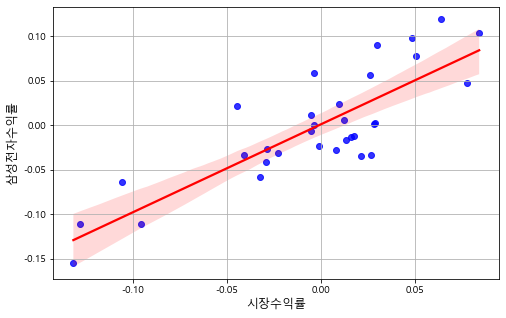

In [10]:
plt.figure(figsize=(8,5))
p = sns.regplot(x=data_m['kospi'],  y=data_m['삼성전자'], 
                scatter_kws={"color": "blue"}, line_kws={"color": "red"}, fit_reg=True)
p.set_xlabel("시장수익률", fontsize = 12)
p.set_ylabel("삼성전자수익률", fontsize = 12)
plt.grid()
plt.show()

In [12]:
# SCL을 바탕으로 회귀계수로 구한 예측값과 실제값간 차이를 구할 수 있다.
error = data_m['삼성전자'] - (capm_model.params[0] + data_m['kospi']*capm_model.params[1])
error.head()

Date
2021-01-31         NaN
2021-02-28   -0.006811
2021-03-31   -0.029934
2021-04-30   -0.027357
2021-05-31   -0.030569
Freq: M, dtype: float64

## Example 3
data 내 모든 기업의 $\alpha, \beta, error$를 산출하고 시장모형의 성능을 평가하시오.

In [13]:
# 1. 각 기업 주식에 대한 SCL parameter값을 구한다.
result = [[c]+ols(f"{c} ~ kospi", data = data_m).fit().params.tolist() for c in data.columns[:-1]]
result = pd.concat([pd.DataFrame(result).set_index(0), data_m.iloc[:,:-1].mean()], axis=1)
result.columns = ['alpha','beta','expRate']
result

,alpha,beta,expRate
삼성전자,0.000730,0.986528,-0.002638
SK하이닉스,0.005617,1.061824,0.001992
현대차,-0.002298,0.687462,-0.004645
셀트리온,-0.016016,0.434150,-0.017498
LG화학,-0.006120,1.071966,-0.009780
POSCO,0.041454,1.623023,0.035913
삼성물산,-0.001264,0.716000,-0.003708
NAVER,-0.005854,1.219687,-0.010018


In [14]:
# 2. 모델 설명력을 확인한다.
# 이론과 달리 beta는 수익률을 제대로 설명하지 못한다. 위험이 커도 수익률은 작을 수 있다는 뜻이다.
stock_model = ols('expRate ~ beta', data=result).fit()
print(stock_model.summary())

                            OLS Regression Results                            
Dep. Variable:                expRate   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     8.606
Date:                Tue, 24 Oct 2023   Prob (F-statistic):             0.0262
Time:                        11:41:33   Log-Likelihood:                 25.750
No. Observations:                   8   AIC:                            -47.50
Df Residuals:                       6   BIC:                            -47.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0343      0.012     -2.877      0.0

In [15]:
# 반대로 alpha는 수익률을 잘 설명한다.
# 즉, 우리나라 주식은 주식시장 위험에 좌지우지 하지 않고 각 회사의 특성(운영, 회계 등)에 따라서만 수익률이 좌우된다.
stock_model = ols("expRate ~ alpha", data = result).fit()
print(stock_model.summary())

                            OLS Regression Results                            
Dep. Variable:                expRate   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2733.
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           3.29e-09
Time:                        11:41:34   Log-Likelihood:                 46.686
No. Observations:                   8   AIC:                            -89.37
Df Residuals:                       6   BIC:                            -89.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0032      0.000    -11.038      0.0

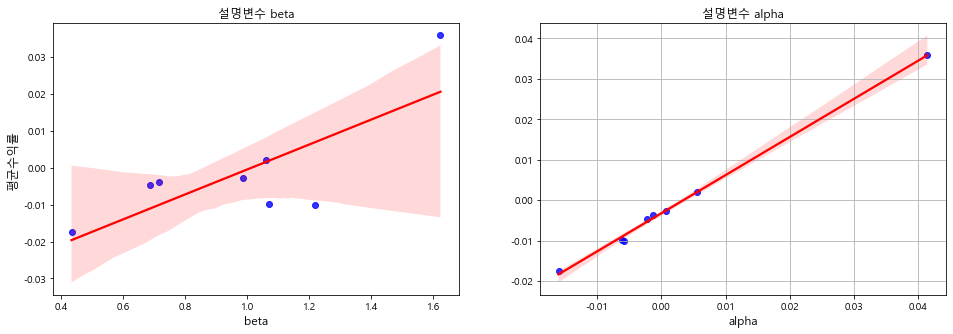

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.regplot(x=result['beta'],  y=result['expRate'], ax=ax[0],
            scatter_kws={"color": "blue"}, line_kws={"color": "red"}, fit_reg=True)
ax[0].set_title("설명변수 beta")
ax[0].set_xlabel("beta", fontsize = 12)
ax[0].set_ylabel("평균수익률", fontsize = 12)

sns.regplot(x=result['alpha'],  y=result['expRate'], ax=ax[1],
            scatter_kws={"color": "blue"}, line_kws={"color": "red"}, fit_reg=True)
ax[1].set_title("설명변수 alpha")
ax[1].set_xlabel("alpha", fontsize = 12)
ax[1].set_ylabel("")
plt.grid()
plt.show()